In [1]:
import os
import glob
import random
import re
import pickle
import gc

import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

import tqdm

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.image import resize_with_pad

from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## Image preprocessing

The approach is simiilar to image processing and bsic EDA for non-DL models, refer to Non-DL notebook for image size analysis, etc

In [32]:
DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_mvp')
folders = os.listdir(DIR_PATH)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\temp_workfolder\\rbc_mvp'

In [3]:
TARGET_HEIGHT = 96
TARGET_WIDTH = 96

In [3]:
def preprocess_img_to_arr(img, target_height = TARGET_HEIGHT, target_width = TARGET_WIDTH):
    img_arr = np.asarray(img)
    img_tensor = tf.convert_to_tensor(img_arr)

    new_img_arr = resize_with_pad(
        img_tensor, 
        target_height, 
        target_width, 
        method = 'nearest',
        antialias = True
    )
    
    return new_img_arr

In [ ]:
# store preprocessed images in new folder
NEW_DIR_PATH = os.path.abspath('C:/temp_workfolder/rbc_mvp/preproc')

In [119]:
if os.path.exists(NEW_DIR_PATH) == False:     #creates a folder if it doesn't exist
        os.mkdir(NEW_DIR_PATH)
    
for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    new_folder_path = os.path.join(NEW_DIR_PATH, folder)
    if os.path.exists(new_folder_path) == False:     #creates a folder if it doesn't exist
        os.mkdir(new_folder_path)
    
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)
        new_img_path = os.path.join(new_folder_path, img)
        
        img = load_img(img_path)
        img_arr = preprocess_img_to_arr(img)
        save_img(new_img_path, img_arr)

=====================================================

### Below is train/test/val splitting the images into according folders

In [8]:
NEW_DIR_PATH2 = os.path.abspath('C:/temp_workfolder/rbc_keras/')

In [9]:
#https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

import splitfolders # or import splitfolders
input_folder = NEW_DIR_PATH2
output = os.path.join(NEW_DIR_PATH2, "keras_split") #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .2, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 7108 files [02:55, 40.50 files/s]


### Use the train-test-split image sets

In [4]:
split_dir = 'C:/temp_workfolder/rbc_keras/keras_split' 
os.listdir(split_dir)

['test', 'train', 'val']

In [5]:
preproc_dir = "C:/temp_workfolder/rbc_keras/keras_split"
os.listdir(preproc_dir)

['test', 'train', 'val']

# ===================

## 0. Augemnting and creating image data
### For NN modelling I will use the train-val-test set obtained from splitfolders 

In [4]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
)

Parameters tuned for NN modeling are image size and batch sizes

In [5]:
train_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/train',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

val_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/val',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

test_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/test',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',   #'categorical'
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 4261 images belonging to 9 classes.
Found 1418 images belonging to 9 classes.
Found 1429 images belonging to 9 classes.


In [6]:
train_gen.class_indices

{'acantocyte': 0,
 'elliptocyte': 1,
 'hypochromic': 2,
 'normal': 3,
 'pencil': 4,
 'spero_bulat': 5,
 'stomatocyte': 6,
 'targetsel': 7,
 'teardrop': 8}

In [7]:
#train_gen.filenames[1000:1010]

In [7]:
X_train, Y_train = next(train_gen)
print(X_train.shape)
print(Y_train.shape)

(32, 96, 96, 3)
(32, 9)


In [8]:
X_val, Y_val = next(val_gen)
print(X_val.shape)
print(Y_val.shape)

(32, 96, 96, 3)
(32, 9)


In [20]:
X_test, Y_test = next(test_gen)
print(X_test.shape)
print(Y_test.shape)

(32, 96, 96, 3)
(32, 9)


## 1. Building a custom CNN model - Initial Attempt
- This was the first attemp at custom CNN model


In [26]:
model = Sequential([
    
    layers.Conv2D(filters=16,kernel_size=3, activation='relu',input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax'),
])

tf.keras.backend.clear_session() 
gc.collect()

1148

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [31]:
gc.collect()


0

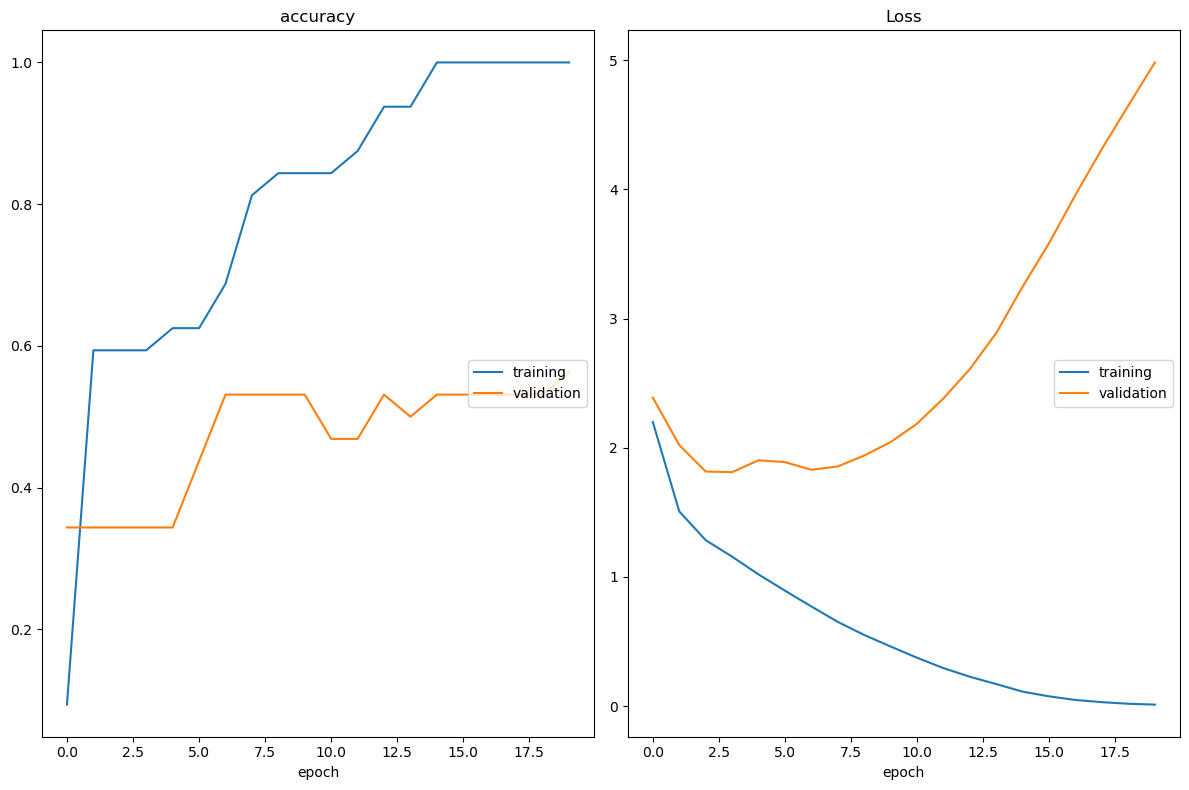

accuracy
	training         	 (min:    0.094, max:    1.000, cur:    1.000)
	validation       	 (min:    0.344, max:    0.562, cur:    0.562)
Loss
	training         	 (min:    0.012, max:    2.199, cur:    0.012)
	validation       	 (min:    1.811, max:    4.984, cur:    4.984)
1/1 [==============================] - 0s 450ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 4.9837 - val_accuracy: 0.5625


48665

In [30]:
model.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()